In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os


In [4]:
dataset_path = '/content/drive/MyDrive/Dataset_ML'


In [5]:
# List folders (classes) in the dataset
print("Classes in the dataset:", os.listdir(dataset_path))


Classes in the dataset: ['0. Cut Shot', '1. Cover Drive', '2. Straight Drive', '3. Pull Shot', '4. Leg Glance Shot', '5. Scoop Shot']


In [6]:
classes = os.listdir(dataset_path)
print("Classes in the dataset:", classes)


Classes in the dataset: ['0. Cut Shot', '1. Cover Drive', '2. Straight Drive', '3. Pull Shot', '4. Leg Glance Shot', '5. Scoop Shot']


In [7]:

for class_name in classes:
    class_folder = os.path.join(dataset_path, class_name)
    image_count = len(os.listdir(class_folder))
    print(f"Class '{class_name}' contains {image_count} images.")


Class '0. Cut Shot' contains 641 images.
Class '1. Cover Drive' contains 600 images.
Class '2. Straight Drive' contains 600 images.
Class '3. Pull Shot' contains 600 images.
Class '4. Leg Glance Shot' contains 600 images.
Class '5. Scoop Shot' contains 600 images.


In [8]:
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical


In [9]:
IMG_SIZE = 224
classes = ['0. Cut Shot', '1. Cover Drive', '2. Straight Drive', '3. Pull Shot', '4. Leg Glance Shot', '5. Scoop Shot']
class_to_label = {name: idx for idx, name in enumerate(classes)}  # Map class names to numeric labels


In [10]:
data = []
labels = []


In [11]:
for class_name in classes:
    class_folder = os.path.join(dataset_path, class_name)
    label = class_to_label[class_name]

    for file_name in os.listdir(class_folder):
        file_path = os.path.join(class_folder, file_name)

        # Read the image
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Failed to load {file_path}. Skipping...")
            continue

        # # Apply Bilateral Filter for noise reduction
        # img = cv2.bilateralFilter(img, 9, 75, 75)  # Using Bilateral Filter

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        img = img / 255.0

        img = img.flatten() #  (SVM requires 1D feature vectors)

        data.append(img)
        labels.append(label)


In [12]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [13]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA

from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


In [14]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


In [15]:
# Train an SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)


SVC(kernel='linear')

In [16]:
# Evaluate the model
y_pred = svm_classifier.predict(X_test)


In [17]:
# Print classification report and accuracy
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=classes))
print("Accuracy Score:", accuracy_score(y_test, y_pred))


Classification Report:
                     precision    recall  f1-score   support

       0. Cut Shot       0.71      0.63      0.66       150
    1. Cover Drive       0.62      0.63      0.62       123
 2. Straight Drive       0.67      0.72      0.69       127
      3. Pull Shot       0.65      0.62      0.64       109
4. Leg Glance Shot       0.69      0.71      0.70       114
     5. Scoop Shot       0.75      0.79      0.77       106

          accuracy                           0.68       729
         macro avg       0.68      0.68      0.68       729
      weighted avg       0.68      0.68      0.68       729

Accuracy Score: 0.6803840877914952


In [18]:
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load the image in grayscale
    if img is None:
        raise ValueError(f"Failed to load image: {image_path}")
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to 224x224
    img = img / 255.0  # Normalize pixel values to [0, 1]
    img = img.flatten()  # Flatten to a 1D array
    return img


In [ ]:
#output visualization

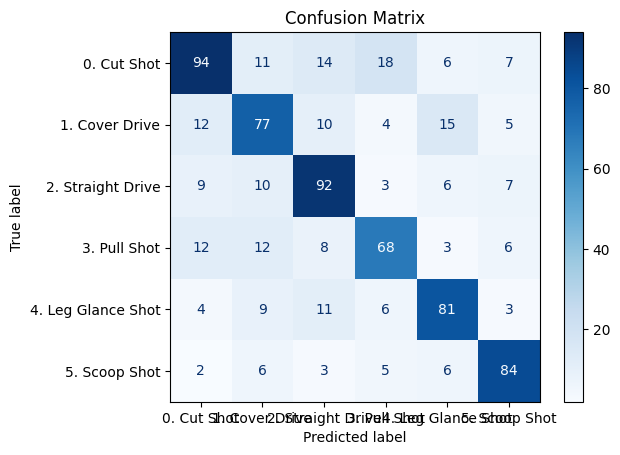

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


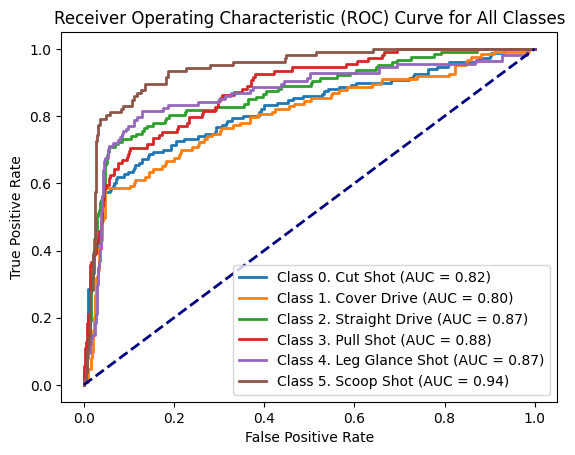

In [21]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize labels for ROC (One-vs-Rest)
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5])
y_pred_prob = svm_classifier.decision_function(X_test)

# Compute ROC curve for each class
fpr, tpr, thresholds = {}, {}, {}
roc_auc = {}

for i in range(len(classes)):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for All Classes')
plt.legend(loc="lower right")
plt.show()
